In [1]:
import numpy as np
import math as math
import copy
import matplotlib.pyplot as plt
from sklearn import preprocessing 
import os
import cv2
import numpy as np
from tqdm import tqdm
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim
import torchvision
from torchvision import transforms, datasets
import csv
import cv2
import glob
from PIL import Image
from sklearn.model_selection import train_test_split
from scipy.integrate import quad
import sklearn
import codecs, json 
import scipy.io
import h5py

device=torch.device("cuda:0")

# Import topnet utilities
import sys
sys.path.insert(0, '/home/ephy/Projects/tda_convolution/src/')
import topnet

In [2]:
REBUILD_DATA = False
datadir = '/home/ephy/Projects/tda_init_cnn/data/'

train = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))
test = datasets.MNIST(datadir+"original/", train=True, download=False, 
                      transform= transforms.Compose([transforms.ToTensor()]))

In [3]:
mnist_train_X = torch.tensor([np.array(i[0]) for i in train])
mnist_test_X = torch.tensor([np.array(i[0]) for i in test])
mnist_train_y = [i[1] for i in train]
mnist_test_y = [i[1] for i in test]

In [4]:
classes=np.unique(mnist_train_y)
mnist_test_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_test_y], dtype=torch.float32)
mnist_train_y = torch.tensor([np.array([int(n) for n in x==classes]) for x in mnist_train_y], dtype=torch.float32)

In [5]:
klein_filters = topnet.legendre_klein_bottle(4,4,5,None)

In [6]:
im = np.array(mnist_train_X[0,0])

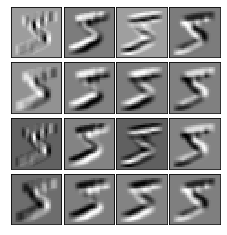

In [7]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(klein_filters):
    filtered_im = cv2.filter2D(im, -1, kernel)
    axarr[i%4,int(np.floor(i/4))].imshow(filtered_im,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=-.7,hspace=.1)
plt.show()

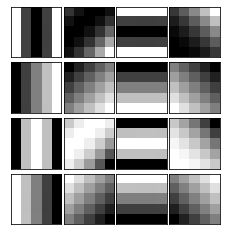

In [8]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(klein_filters):
    axarr[i%4,int(np.floor(i/4))].imshow(kernel,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=-.7,hspace=.1)
plt.show()

In [14]:
circle_filters = topnet.primary_circle(5,16,None)

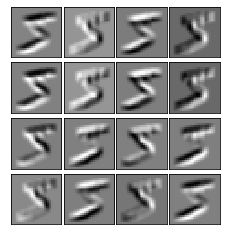

In [15]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(circle_filters):
    filtered_im = cv2.filter2D(im, -1, kernel)
    axarr[i%4,int(np.floor(i/4))].imshow(filtered_im,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=-.7,hspace=.1)
plt.show()

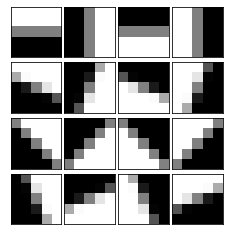

In [16]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(circle_filters):
    axarr[i%4,int(np.floor(i/4))].imshow(kernel,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=-.69,hspace=.1)
plt.show()

In [19]:
class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(1, 16, 5)
        
        x= torch.randn(28,28).view(-1,1,28,28)
        self._to_linear = None
        self.convs(x)
        
        self.fc1 = nn.Linear(self._to_linear, 5000)
        self.fc2 = nn.Linear(5000, 10)
        
    def convs(self, x):
        x = F.relu(self.conv1(x))
        
        if self._to_linear is None:
            self._to_linear = x[0].shape[0]*x[0].shape[1]*x[0].shape[2]
            
        return x
    
    def forward(self, x):
        # reshape inside of array
        x = self.convs(x)
        x = x.view(-1, self._to_linear)
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return F.softmax(x, dim=1)
net = Net().to(device)
optimizer = optim.Adam(net.parameters(), lr=1e-5)

In [20]:
batchSize = 100
lossrec=[]
for n in range(0, len(mnist_train_X), batchSize):
    batch_X = mnist_train_X[n:n+batchSize].view(-1,1,28,28).to(device)
    batch_y = mnist_train_y[n:n+batchSize].to(device)
    net.zero_grad()
    outputs = net(batch_X)
    loss = nn.MSELoss()(outputs, batch_y)
    lossrec.append(loss.tolist())
    loss.backward()
    optimizer.step()

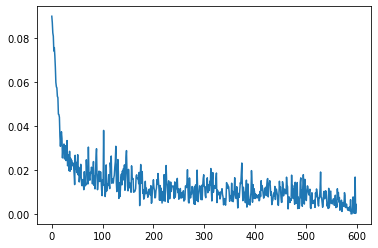

In [186]:
plt.plot(lossrec)

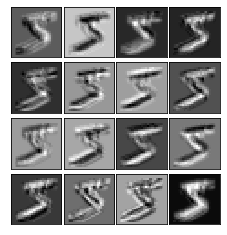

In [21]:
with torch.no_grad():
    fig, axarr = plt.subplots(4,4)
    for i, kernel in enumerate(np.array(net.conv1.weight.cpu())):
        filtered_im = cv2.filter2D(im, -1, kernel[0])
        axarr[i%4,int(np.floor(i/4))].imshow(filtered_im,cmap='gray')
    plt.setp(axarr, xticks=[], yticks=[])
    plt.subplots_adjust(wspace=-.7,hspace=.1)
    plt.show()

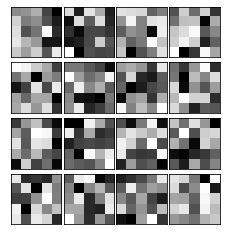

In [22]:
with torch.no_grad():
    fig, axarr = plt.subplots(4,4)
    for i, kernel in enumerate(np.array(net.conv1.weight.cpu())):
        filtered_im = cv2.filter2D(im, -1, kernel[0])
        axarr[i%4,int(np.floor(i/4))].imshow(kernel[0],cmap='gray')
    plt.setp(axarr, xticks=[], yticks=[])
    plt.subplots_adjust(wspace=-.7,hspace=.1)
    plt.show()

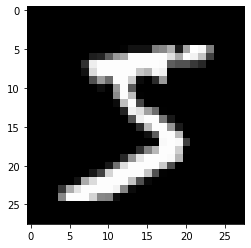

In [200]:
plt.imshow(im, cmap='gray')

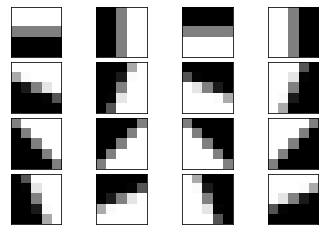

In [17]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(circle_filters):
    axarr[i%4,int(np.floor(i/4))].imshow(kernel,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=.1,hspace=.1)
plt.show()

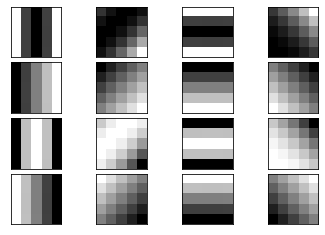

In [18]:
fig, axarr = plt.subplots(4,4)
for i, kernel in enumerate(klein_filters):
    axarr[i%4,int(np.floor(i/4))].imshow(kernel,cmap='gray')
plt.setp(axarr, xticks=[], yticks=[])
plt.subplots_adjust(wspace=.1,hspace=.1)
plt.show()

In [204]:
torch.cuda.empty_cache()